In [1]:
import cv2
import matplotlib.pyplot as plt


In [2]:
img=cv2.imread("./messipic/messi_score.jpg")
img.shape

(412, 612, 3)

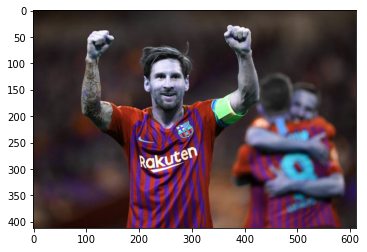

In [3]:
plt.imshow(img)

In [4]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(412, 612)

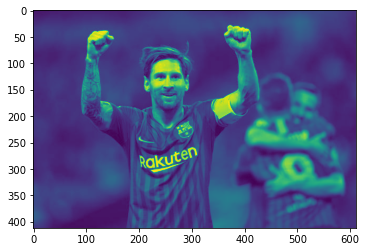

In [5]:
plt.imshow(gray)

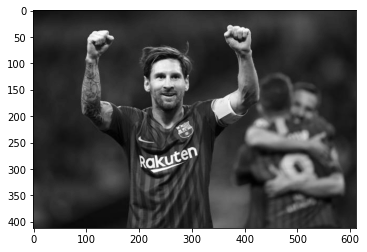

In [6]:
plt.imshow(gray,cmap='gray')
plt.savefig("origin_gray.png",idp=300)

In [7]:
face_cascade=cv2.CascadeClassifier("/home/kit/Projects/Imageclaasification/py-DataScience-CelebrityFaceRecognition-model-opencv-haarcascades/haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier("/home/kit/Projects/Imageclaasification/py-DataScience-CelebrityFaceRecognition-model-opencv-haarcascades/haarcascade_eye.xml")
faces=face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[211,  92,  89,  89]], dtype=int32)

In [8]:
(x,y,w,h)=faces[0]
x,y,w,h

(211, 92, 89, 89)

In [9]:
face_img=cv2.rectangle(img,(x,y),(x+h,y+h),(255,0,0),2)

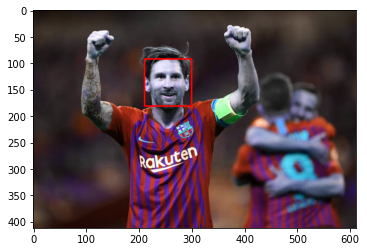

In [10]:
plt.imshow(face_img)

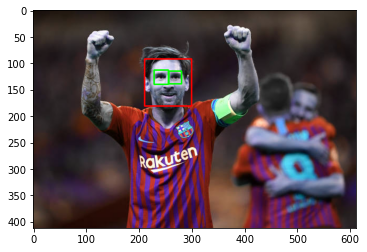

In [11]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img,cmap="gray")
plt.savefig("face_eye.png",idp=300)
plt.show()



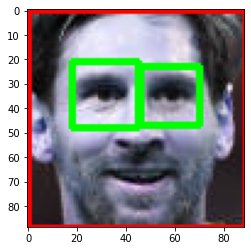

In [12]:
%matplotlib inline
plt.imshow(roi_color,cmap="gray")
plt.savefig("crop_eye.png",dpi=300)

In [13]:
def get_crop(images_path):
    img=cv2.imread(images_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=img[y:y+h,x:x+w]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color
        

In [14]:
crop_pic=get_crop("./messipic/messi1.jpg")
crop_pic

In [15]:
path_to_data="./Dataset/"
path_to_cr="./Dataset/cropped/"

In [16]:
import os 
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [17]:
img_dirs

['./Dataset/roger_federer',
 './Dataset/lionel_messi',
 './Dataset/maria_sharapova',
 './Dataset/cropped',
 './Dataset/.ipynb_checkpoints']

In [18]:
import shutil
if os.path.exists(path_to_cr):
    shutil.rmtree(path_to_cr)
os.mkdir(path_to_cr)
    

In [19]:
dict_celi_pic={}
crop_folder_of_img=[]
for img_dir in img_dirs:
    count=1
    celibraties_name=img_dir.split("/")[-1]
    dict_celi_pic[celibraties_name]=[]
    for img in os.scandir(img_dir):
        roi_color=get_crop(img.path)
        if roi_color is not None:
            crope_dir=path_to_cr+celibraties_name
            if not os.path.exists(crope_dir):
                os.mkdir(crope_dir)
                crop_folder_of_img.append(crope_dir)
            file_pic=crope_dir+"/"+celibraties_name+str(count)+".png"
            count+=1
            cv2.imwrite(file_pic,roi_color)
            dict_celi_pic[celibraties_name].append(file_pic)

        
                
                
        

error: OpenCV(3.4.8) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# wavelet transform

In [20]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

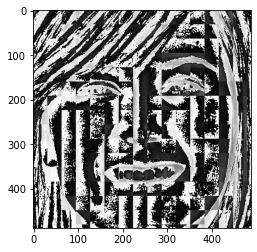

In [21]:
c=np.array(roi_color)
img_har=w2d(c,"db1",5)
plt.imshow(img_har,cmap="gray")
# plt.savefig("wavelet_image.png",dpi=300)

In [22]:
path_nmae=os.scandir("./Dataset/cropped/")
names={}
count=0
for i in path_nmae:
    names[i.path.split("/")[-1]]=count
    count+=1
names

{'roger_federer': 0, 'lionel_messi': 1, 'maria_sharapova': 2}

### we can see clearly the edge of eyes and another facial feature like nose,lips,etc

In [23]:
x=[]
y=[]
for cele_name,file_list in dict_celi_pic.items():
    for file in file_list:
        img=cv2.imread(file)
        scale_raw_image=cv2.resize(img,(32,32))
        img_har=w2d(img,"db1",5)
        scale_img_har=cv2.resize(img_har,(32,32))
        combine=np.vstack((scale_raw_image.reshape(32*32*3,1),scale_img_har.reshape(32*32,1)))
        x.append(combine)
        y.append(names[cele_name])

# Built model

In [24]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [25]:
model=SVC()
x1=np.array(x).reshape(len(x),4096).astype(float)
x1

array([[ 16.,  18.,  26., ..., 253., 241.,   4.],
       [ 22.,  33.,  54., ..., 222., 220., 216.],
       [  2.,   7.,  10., ...,  28., 206., 227.],
       ...,
       [  8.,   4.,  16., ..., 228.,  35.,  61.],
       [168., 176., 192., ..., 213., 226.,   1.],
       [ 84.,  77.,  74., ..., 225., 223.,   3.]])

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline,make_pipeline
import pandas as pd

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x1,y,random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svk', SVC(kernel = 'rbf', C = 10))])
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.8846153846153846

In [70]:
models={
    "logistic_resgression":{
        "model":LogisticRegression(),
        "params":{
            "logisticregression__C":[1,10,20]
        }
    },
     "svm":{
            "model":SVC(gamma="auto",probability=True),
            "params":{
                "svc__kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                'svc__C':[1,10,20]
            }
        },
    "random_forest":{
        "model":RandomForestClassifier(),
        "params":{
            'randomforestclassifier__n_estimators':[1,10,100]
        }
    }
}

In [71]:
score=[]
for model_name,model in models.items():
    pipe=make_pipeline(StandardScaler(),model["model"])
    cv=GridSearchCV(pipe,model["params"])
    cv.fit(x_train,y_train)
    score.append({
        "name":model_name,
        "best_score":cv.best_score_,
        "best_params":cv.best_params_
    })
score

/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 179, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 62x4096 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitF

/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 179, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 62x4096 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/kit/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitF

[{'name': 'logistic_resgression',
  'best_score': 0.8724999999999999,
  'best_params': {'logisticregression__C': 1}},
 {'name': 'svm',
  'best_score': 0.8725000000000002,
  'best_params': {'svc__C': 1, 'svc__kernel': 'linear'}},
 {'name': 'random_forest',
  'best_score': 0.8333333333333334,
  'best_params': {'randomforestclassifier__n_estimators': 100}}]

In [72]:
scores=pd.DataFrame(score)
scores


,name,best_score,best_params
0,logistic_resgression,0.872500,{'logisticregression__C': 1}
1,svm,0.872500,"{'svc__C': 1, 'svc__kernel': 'linear'}"
2,random_forest,0.833333,{'randomforestclassifier__n_estimators': 100}


In [76]:
model=SVC(gamma="auto",probability=True,C=1,kernel="linear")
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.8846153846153846

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [80]:
cm=confusion_matrix(y_test,model.predict(x_test))
cm

array([[8, 0, 1],
       [1, 9, 1],
       [0, 0, 6]])

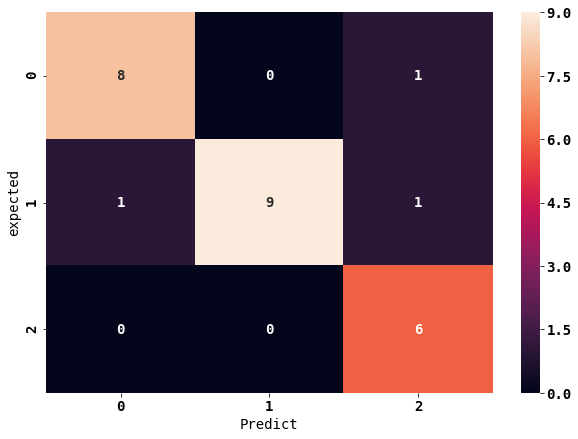

In [98]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predict")
font = {'family' : 'monospace',
          'weight' : 'bold',
          'size'   : 18}
plt.rc('font', **font)
plt.ylabel("expected")
plt.savefig("result.png")

In [83]:
import pickle

In [84]:
with open ("model.pickle","wb") as f:
    pickle.dump(model,f,protocol=2)

In [85]:
import joblib

In [87]:
joblib.dump(model,"model.pkl")

['model.pkl']

In [103]:
import json
with open("name.json","w") as f:
    f.write(json.dumps(names))